In [56]:
'''!pip install -q tensorflow==2.1.0
!pip install -q tensorflow-quantum
!pip install qiskit
!pip install cirq
'''

'!pip install -q tensorflow==2.1.0\n!pip install -q tensorflow-quantum\n!pip install qiskit\n!pip install cirq\n'

In [57]:
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time 
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
%matplotlib inline

## Classical Data Preparation

In [2]:
'''
from google.colab import drive
drive.mount('/content/drive')
X = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Input_data_ML.npy')
Y = np.load('/content/drive/My Drive/Quantum Research/QML Scattering/Classical ML Scattering/Output_data_ML.npy')
'''

X = np.load('Input_data_ML.npy')
Y = np.load('Output_data_ML.npy')

In [3]:
#Mean_Norm Scaling of X
x_mean=np.mean(np.mean(X,axis=0),axis=0)
X=X-x_mean
X=X/np.reshape(np.linalg.norm(X,axis=1),(-1,1))

'''
#Normalising X
x_mean=np.mean(np.mean(X,axis=0),axis=0)
x_std=np.std(np.std(X,axis=0),axis=0)
X=(X-x_mean)/x_std
'''

'\n#Normalising X\nx_mean=np.mean(np.mean(X,axis=0),axis=0)\nx_std=np.std(np.std(X,axis=0),axis=0)\nX=(X-x_mean)/x_std\n'

In [4]:
#Processing Y
Y=Y.T

Y[Y[:,11]>2*np.pi,11]=Y[Y[:,11]>2*np.pi,11]-2*np.pi
Y[Y[:,11]<0,11]=Y[Y[:,11]<0,11]+2*np.pi
#Output[:,12:]=Output[:,12:]+2.0*np.pi

#Y=np.log(Y)
R=np.array([i for i in range(Y.shape[0])])
np.random.shuffle(R)
X=X[R,:]
Y=Y[R,:]  

Q1=np.quantile(Y,0.10,axis=0)
Q3=np.quantile(Y,0.90,axis=0)
IQR=Q3-Q1
X=X[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]
Y=Y[~((Y < (Q1 - 1.5 * IQR)) |(Y > (Q3 + 1.5 * IQR))).any(axis=1)]

'''
#Standard Scaling of Y
y_mean=np.mean(Y,axis=0)
y_std=np.std(Y,axis=0)
Y=(Y-y_mean)/y_std
'''

Y=Y[:,0]

#Min_Max Scaling of Y
y_min=np.min(Y,axis=0)
Y=Y-y_min
y_max=np.max(Y,axis=0)
Y=Y/y_max

'''
#Unit Sum Scaling of Y
Y=Y/np.reshape(np.sum(Y,axis=1),(-1,1))
'''

print(np.shape(X),np.shape(Y))

(1050055, 38) (1050055,)


In [5]:
#Expanding X to a 64-dimensional vector and Y to a 16-dimensional vector. So that log(N) is an integer. 

m=np.shape(X)[0]

X_expand=np.zeros((m,64))
X_expand[:,:38]=X

Y_expand=Y
#Y_expand=np.zeros((m,16))
#Y_expand[:,:15]=Y

print(np.shape(X_expand),np.shape(Y_expand))

(1050055, 64) (1050055,)


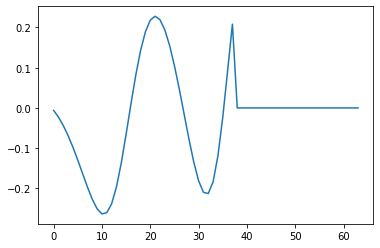

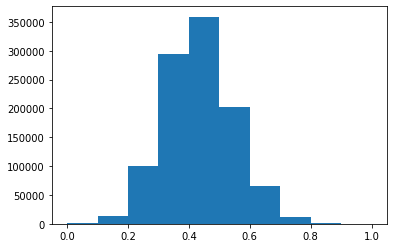

In [7]:
key=20000
plt.plot(X_expand[key])
plt.show()
plt.hist(Y_expand)
plt.show()

#### Working with a small dataset 

In [81]:
key=np.random.randint(m,size=1000)

X_small=X_expand[key]
Y_small=Y_expand[key]

## Quantum Neural Network

In [82]:
n_wires=6

dev = qml.device("default.qubit", wires=n_wires) #qml.device("forest.qvm", device="Aspen-4-4Q-F")

In [83]:
@qml.qnode(dev)
def quantum_neural_net(params, x=None):
    # Encode input x into quantum state
    qml.QubitStateVector(x,wires=list(range(n_wires)))
    
    n=n_wires
    
    for i in range(n_wires):
        for j in range(n_wires):
            qml.RX(params[3*n*i+3*j],wires=j)
            qml.RY(params[3*n*i+3*j+1],wires=j)
            qml.RZ(params[3*n*i+3*j+2],wires=j)
        for j in range(n):
            if i==j: continue
            qml.CNOT(wires=[i,j])
    for j in range(n):
        qml.RX(params[3*n**2+3*j],wires=j)
        qml.RY(params[3*n**2+3*j+1],wires=j)
        qml.RZ(params[3*n**2+3*j+2],wires=j)

    return qml.expval(qml.PauliZ(n_wires-1))

In [84]:
#Variable Initialization
var_init=np.random.rand(3*n_wires*(n_wires+1))*2*np.pi-np.pi

quantum_neural_net(var_init, x=X_small[0,:])

0.021600302778376768

In [85]:
print(quantum_neural_net.draw())

 0: ──╭QubitStateVector(M0)──RX(-0.061)──RY(1.388)───RZ(-3.079)──╭C────────────╭C──────────────╭C──────────────╭C──────────────╭C──RX(-1.655)──RY(1.661)───RZ(-1.62)───╭X───RX(-2.83)──RY(1.323)───────RZ(1.197)───────────────────────────────────╭X──RX(-1.502)──RY(0.3)──────RZ(-1.574)────────────────────────────────────────────────────────────────────╭X──RX(1.552)────────RY(-1.327)───RZ(-2.612)──────────────────────────────────────────────────────╭X───RX(-1.297)───RY(-2.13)────RZ(-1.998)──────────────────────────────────────────────────╭X───RX(1.025)───RY(-1.246)───RZ(0.405)────────────────────────────────────────────────────┤     
 1: ──├QubitStateVector(M0)──RX(2.939)───RY(-0.811)──RZ(2.052)───╰X──RX(1.28)──│───RY(-3.114)──│───RZ(2.225)───│───────────────│───────────────────────────────────────╰C──╭C──────────────────────╭C──────────────╭C──────────────╭C──RX(-2.06)───│───RY(1.715)───RZ(-2.163)──╭X────────────RX(-0.1)──RY(2.907)──────RZ(-3.051)──────────────────────────────│────────────

In [86]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [87]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x=x) for x in features]
    print('@',end='')
    return square_loss(labels, preds)

In [ ]:
opt = AdamOptimizer(0.1, beta1=0.9, beta2=0.999)

var = var_init
for it in range(10):
    t=time.time()
    var = opt.step(lambda v: cost(v, X_small, Y_small), var)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(var, X_small, Y_small)),'\t',time.time()-t)

@

In [ ]:
predictions = [quantum_neural_net(var, x=x) for x in X]

In [ ]:
#1. Run Time Analysis
#2. Compare PQC using PauliSum against Expectation Layer  (Should be the same)